[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed. 



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

def pomnozimacke(a: int, b: int) -> int:
    """Multiplies two numbers and returns the result."""
    print("pomnozimacke ARGS", a, "and", b)
    print("pomnozimacke Resolving ", a * b)
    return a * b

def divide(a: int, b: int) -> float:
    """Divides two numbers and returns the result."""
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    print("divide ARGS", a, "and", b)
    print("divide Resolving ", a / b)
    return a / b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([pomnozimacke, divide])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

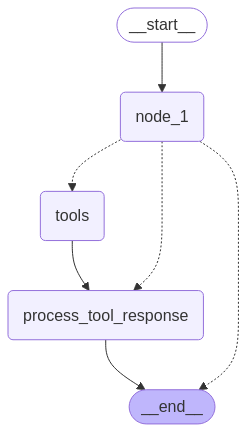

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def custom_tools_condition(state: MessagesState) -> str:
    """Routes execution based on whether the last message contains a tool call."""
    print("1. custom_tools_condition",state["messages"][-1])


    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and hasattr(last_message, "tool_calls") and last_message.tool_calls:
        print("2. custom_tools_condition - Returning tools")
        return "tools"
    print("3. custom_tools_condition - Returning node_1")
    return END

def calling_llm(state: MessagesState):
    print("1. Calling LLM with binded Tools :", state["messages"])
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def process_tool_response(state: MessagesState):
    """Passes tool results back to the LLM for further processing."""
    return {"messages": [llm.invoke(state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("node_1", calling_llm)
builder.add_node("tools", ToolNode([pomnozimacke, divide]))
builder.add_node("process_tool_response", process_tool_response)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", custom_tools_condition)
builder.add_edge("tools", "process_tool_response")
builder.add_edge("process_tool_response", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Multiply 5 and 7.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

1. Calling LLM with binded Tools : [HumanMessage(content='Multiply 5 and 7.', additional_kwargs={}, response_metadata={}, id='a9756f90-a170-41d5-bc85-59101e15e1f2')]
1. custom_tools_condition content='' additional_kwargs={'tool_calls': [{'id': 'call_1VS9G7Mcc0r2pWW7rZ09rmMH', 'function': {'arguments': '{"a":5,"b":7}', 'name': 'pomnozimacke'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 87, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-23cd5f08-7824-4771-bc62-27b385717485-0' tool_calls=[{'name': 'pomnozimacke', 'args': {'a': 5, 'b': 7}, 'id': 'call_1VS9G7Mcc0r2pWW7rZ09rmMH', 'type': 'tool_call'}] usage_metadat

Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `router` in Studio, which uses `module-1/studio/router.py` set in `module-1/studio/langgraph.json`.